In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import cmasher as cmr # Import CMasher to register colormaps
import matplotlib as mpl
from deconvolution_utils import pyklip_rotate
from nircam_disk_utils import quad_disk_model_hg3
import matplotlib.patches as patches

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'cmr.freeze'

# Read in and combine the deconvolved images

In [2]:
deoconvolved_data_Dir = "/home/maxmb/Library/jwst_ers_NIRCAM_HD141569A/Deconvolution/decon_data/"

f300m_filename = "JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASKA335R_SUB320A335R_mcrdi_psfsub_deconv.fits"
f360m_filename = "JWST_NIRCAM_NRCALONG_F360M_MASKRND_MASKA335R_SUB320A335R_mcrdi_psfsub_deconv.fits"

f300m_hdu = fits.open(deoconvolved_data_Dir+f300m_filename)
f300m_data = np.rot90(f300m_hdu[1].data) #Rotate it so the sma is horizontal
f360m_data = np.rot90(fits.open(deoconvolved_data_Dir+f360m_filename)[1].data)

# Read in the Model

In [3]:
######################################
######### Simulation Setup ###########
######################################
pixel_scale=0.063 # nircam pixel scale in arcsec/px
nx = 140 # number of pixels of your image in X
ny = 140 # number of pixels of your image in Y
cent = [173.4,149.1] #[y_cent,x_cent] #Cropped cent

########################################################
######### Scaling values for some parameters ###########
########################################################

############# SMA ##############
#Parameters from October
a0_1 = 40.0  # semimajoraxis of the inner disk in au
a0_2 = 220.0  # semimajoraxis of the inner disk in au
a0_3 = 510.0  # semimajoraxis of the inner disk in au
a0_4 = 330.0

################# Relative flux #####################
#Parameters from October
f0_1 = 3e4
f0_2 = 7.5e3
f0_3 = 140
f0_4 = 410

# A scaling factor because the new data slightly brighter than the old data
new_flux_scaling = 1.23
f0_1 *= new_flux_scaling
f0_2 *= new_flux_scaling
f0_3 *= new_flux_scaling
f0_4 *= new_flux_scaling

x0_f300m = np.load("hg3fit_F300M_m_stars_bounded_quad_new.npz.npy")
x0_f300m[1] = np.radians(86.4)

In [4]:
#Generate the model: 
model_center = [70.,70.]
model_image = quad_disk_model_hg3(x0_f300m, [70.,70], 
                                   f0_1=f0_1, f0_2=f0_2, f0_3=f0_3, f0_4=f0_4,
                                      a0_1=a0_1, a0_2=a0_2, a0_3=a0_3, a0_4=a0_4,)


/home/maxmb/anaconda3/envs/new_jax_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


In [5]:
pixel_scale_f300m = np.sqrt(f300m_hdu[1].header['PIXAR_A2'])

#Coronagraphic center: 
coron_center = [173.4,149.1]
# coron_center = [210,210]

#F300M - pixel sizes and plotting range. 
x_size_f300m = f300m_data.shape[1]
y_size_f300m = f300m_data.shape[0]
x_f300m = np.arange(x_size_f300m)
y_f300m = np.arange(y_size_f300m)
x_f300m = (x_f300m-coron_center[0])*pixel_scale_f300m
y_f300m = (y_f300m-(y_size_f300m-coron_center[1]))*pixel_scale_f300m

x_f300m_model = np.arange(model_image.shape[1])
y_f300m_model = np.arange(model_image.shape[0])
x_f300m_model = (x_f300m_model-model_center[1])*pixel_scale_f300m
y_f300m_model = (y_f300m_model-model_center[0])*pixel_scale_f300m


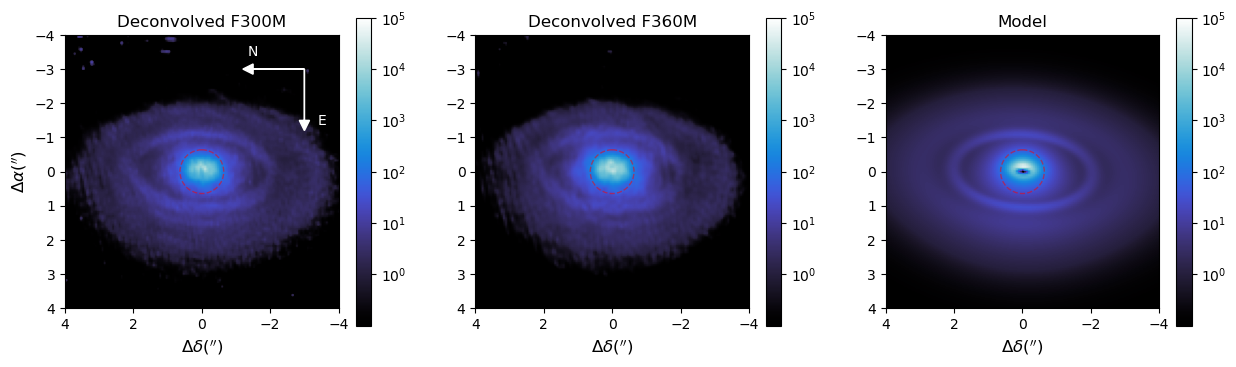

In [7]:
f300m_vmin = 0.1
f300m_vmax = 100000

f360m_vmin = 0.1
f300m_vmax = 100000

linthresh = 1
# gamma = 0.3
# f300m_deconvolution_norm = mpl.colors.PowerNorm(gamma=gamma,vmin=f300m_vmin,vmax=f300m_vmax)
# f300m_deconvolution_norm = mpl.colors.LogNorm(vmin=f300m_vmin,vmax=f300m_vmax)
# f360m_deconvolution_norm = mpl.colors.LogNorm(vmin=f360m_vmin,vmax=f300m_vmax)

# f300m_deconvolution_norm = mpl.colors.LogNorm(vmin=f300m_vmin,vmax=f300m_vmax)
# f360m_deconvolution_norm = mpl.colors.LogNorm(vmin=f360m_vmin,vmax=f300m_vmax)

f300m_deconvolution_norm = mpl.colors.SymLogNorm(vmin=f300m_vmin,vmax=f300m_vmax,linthresh=linthresh)
f360m_deconvolution_norm = mpl.colors.SymLogNorm(vmin=f360m_vmin,vmax=f300m_vmax,linthresh=linthresh)

fig, axes = plt.subplots(1,3,figsize=(15,4))
axes = axes.flatten()

im0 = axes[0].imshow(f300m_data,norm = f300m_deconvolution_norm,
               extent=[x_f300m[0],x_f300m[-1],y_f300m[0],y_f300m[-1]])
plt.colorbar(im0,ax=axes[0])
axes[0].set_title("Deconvolved F300M")

im1 = axes[1].imshow(f360m_data,norm = f360m_deconvolution_norm,
               extent=[x_f300m[0],x_f300m[-1],y_f300m[0],y_f300m[-1]])
plt.colorbar(im1,ax=axes[1])
axes[1].set_title("Deconvolved F360M")

im2 = axes[2].imshow(4*model_image,norm = f300m_deconvolution_norm,
               extent=[x_f300m_model[0],x_f300m_model[-1],y_f300m_model[0],y_f300m_model[-1]])
plt.colorbar(im2,ax=axes[2])
axes[2].set_title("Model")

axes[0].set_xlim(4,-4)
axes[0].set_ylim(4,-4)

axes[1].set_xlim(4,-4)
axes[1].set_ylim(4,-4)

axes[2].set_xlim(4,-4)
axes[2].set_ylim(4,-4)

axes[0].set_xlabel(r"$\Delta \delta ('')$",fontsize=12)
axes[0].set_ylabel(r"$\Delta \alpha ('')$",fontsize=12)

axes[1].set_xlabel(r"$\Delta \delta ('')$",fontsize=12)
axes[2].set_xlabel(r"$\Delta \delta ('')$",fontsize=12)

fpm_radius = 0.64 #Radius of MASK335R
for ax in axes:
    # Create a circle with x and y at the center
    circle = patches.Circle((0.,0.), fpm_radius, edgecolor='red', facecolor='none',linestyle="--",alpha=0.5)

    # Add the circle to the axes
    ax.add_patch(circle)

# roll_angle_f300m = f300m_roll1_hdul[1].header['ROLL_REF']
roll_angle_f300m = 90
north_angle = roll_angle_f300m + 270
east_angle = (roll_angle_f300m + 180) % 360  # East is counterclockwise of North
# Assuming ax is your axis object
arrow_length = 1.5
compass_center = [-3,-3]
# Draw North arrow
axes[0].arrow(compass_center[0], compass_center[1], arrow_length * np.cos(np.radians(north_angle)), -arrow_length * np.sin(np.radians(north_angle)), head_width=0.3, head_length=0.3, fc='w', ec='w')
# Draw North label
axes[0].text(arrow_length * np.cos(np.radians(north_angle))+compass_center[0], -arrow_length * np.sin(np.radians(north_angle))+compass_center[1]-0.5, 'N', color='w', ha='center', va='center')

# Draw East arrow
axes[0].arrow(compass_center[0], compass_center[1], arrow_length * np.cos(np.radians(east_angle)), -arrow_length * np.sin(np.radians(east_angle)), head_width=0.3, head_length=0.3, fc='w', ec='w')
# Draw East label
axes[0].text(arrow_length * np.cos(np.radians(east_angle))+compass_center[0]-0.5, -arrow_length * np.sin(np.radians(east_angle))+compass_center[1], 'E', color='w', ha='center', va='center')


plt.savefig("Deconvolved_F300M_F360M_Model.png",dpi=300,bbox_inches="tight")